<a href="https://colab.research.google.com/github/Dani08-C/FakeNews/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Descripción: La intencionalidad de este programa es detectar noticias verdaderas (0) y falsas (1)

In [4]:
#Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import nltk
import re

from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

##Fake Dataset

In [5]:
#Cargar dataset
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')

In [6]:
fake.head()


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [10]:
fake['subject'].value_counts()


News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


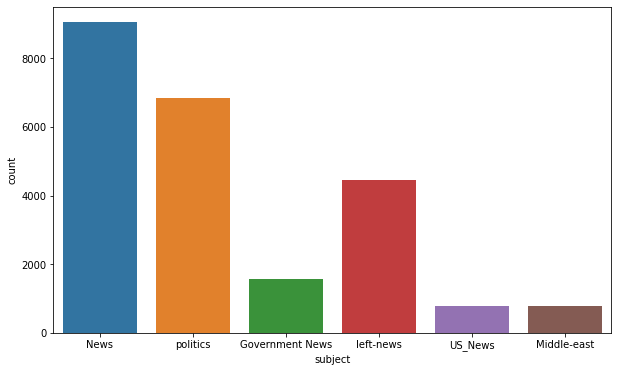

In [7]:
plt.figure(figsize=(10,6))
sns.countplot('subject',data=fake)

In [14]:
text = ' '.join(fake['text'].tolist())

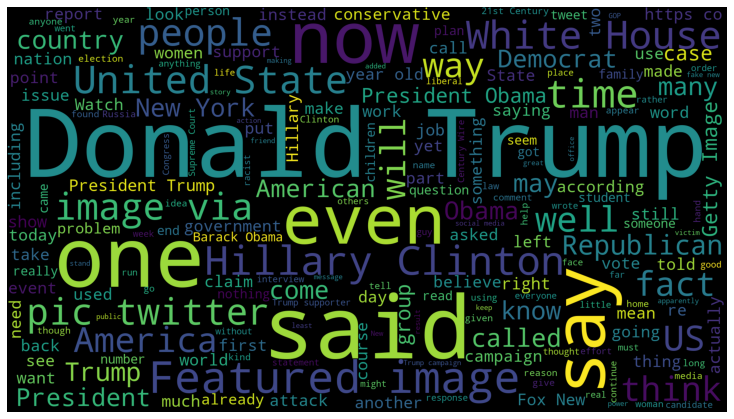

In [21]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##True Dataset

In [8]:
#Cargar dataset
true = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')

In [23]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [24]:
true.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


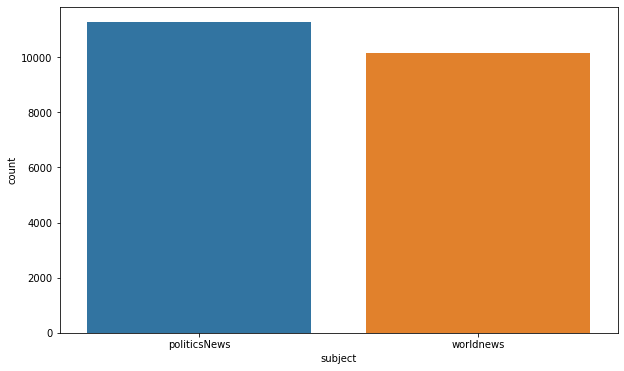

In [25]:
plt.figure(figsize=(10,6))
sns.countplot('subject',data=true)

In [9]:
text = ' '.join(true['text'].tolist())

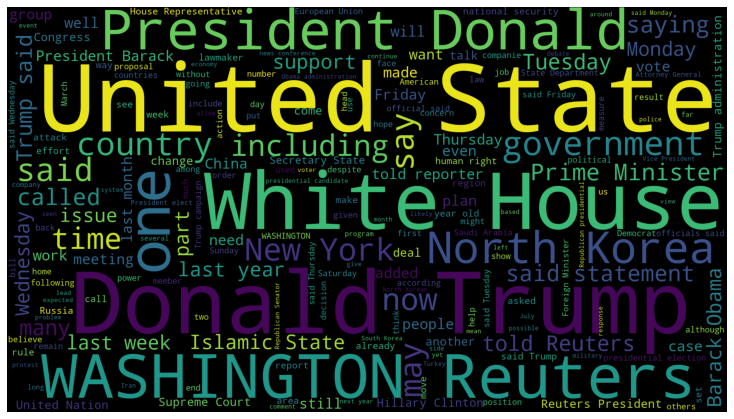

In [27]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##Limpiando el DataSet


In [10]:
unknown_publisher =[]
for index, row in enumerate(true.text.values):
  try:
    record = row.split("-", maxsplit = 1)
    record[1]
    assert(len(record[0])<120)
  except: 
    unknown_publisher.append(index)

In [44]:
len(unknown_publisher)

221

In [ ]:
true.iloc[unknown_publisher].text

In [11]:
#Elimina los registros que no contienen texto
true = true.drop(8970, axis=0)

In [13]:
#Identifica los registros que no tienen publisher
from pandas.core.common import temp_setattr
publisher = []
tmp_text = []
for index, row in enumerate(true.text.values):
  if index in unknown_publisher:
    tmp_text.append(row)
    publisher.append('Unknown')
  else:
   record = row.split('-',maxsplit=1)
   publisher.append(record[0].strip())
   tmp_text.append(record[1].strip() ) 

In [14]:
true['publisher']=publisher
true['text']=tmp_text

In [ ]:
true.head()

In [15]:
empty_fake_index= [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [ ]:
fake.iloc[empty_fake_index]

In [17]:
true['text']=true['text']+" "+true['text']
fake['text']=fake['text']+" "+fake['text']

In [18]:
#Convertir a lowercase
true['text']= true['text'].apply(lambda x:str(x).lower())
fake['text']= fake['text'].apply(lambda x:str(x).lower())

##Preprocesamiento del texto

In [19]:
#Se asigna 1 a las verdaderas y 0 a las falsas
true['class']=1
fake['class']=0

In [20]:
true = true[['text','class']]

In [21]:
fake = fake[['text','class']]

In [22]:
#se combinan estos registros solo teniendo en cuenta los datos de texto y clase
data = true.append(fake, ignore_index=True)

In [ ]:
data.sample(5)

In [ ]:
#Preprocesamiento tomado de https://github.com/laxmimerit/preprocess_kgptalkie.git

In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

In [24]:
import preprocess_kgptalkie as ps

In [25]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [ ]:
data.head()

##Word2vec

In [26]:
#Tecnica de vectorización para convertir los datos textuales en numericos
import gensim

In [27]:
y = data['class'].values

In [28]:
X = [d.split() for d in data['text'].tolist()]

In [29]:
#Convierte cada palabra en una secuencia de 100 vectores
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences = X, size=DIM, window =10, min_count=1)

In [30]:
len(w2v_model.wv.vocab)

228225

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [32]:
X =tokenizer.texts_to_sequences(X)

In [ ]:
tokenizer.word_index

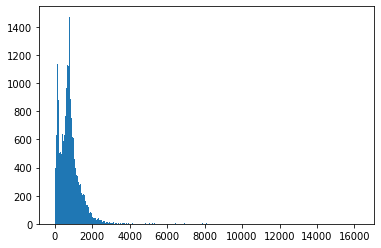

In [34]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [35]:
nos = np.array([len(x) for x in X])
len(nos[nos>2000])

1500

In [36]:
maxlen = 2000
x = pad_sequences(X, maxlen=maxlen)


In [37]:
vocab_size = len(tokenizer.word_index) +1
vocab =tokenizer.word_index

In [38]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]
  
  return weight_matrix

In [39]:
embedding_vectors = get_weight_matrix(w2v_model)

In [40]:
embedding_vectors.shape

(228226, 100)

In [41]:
#Creación del modelo de machine learning
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights= [embedding_vectors], input_length=maxlen, trainable= False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         22822600  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 22,939,977
Trainable params: 117,377
Non-trainable params: 22,822,600
_________________________________________________________________


In [43]:
#Entrenamiento de la red neuronal

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

In [47]:
y_pred = (model.predict(X_test)>=0.5).astype(int)

In [ ]:
accuracy_score(y_test, y_pred)